In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='1'


# %pip install comet_ml
from comet_ml import Experiment

### This notebook:
###### 1. Super-quick intro into BaBar DIRC subdetector
###### 2. You create a WGAP-GP GAN

###### BaBar DIRC:
![image](https://www.slac.stanford.edu/BFROOT/www/Detector/DIRC/Gifs/NewDirc.gif)

Detection of Internally Reflected Cherenkov light - a particle identification detector in other words.
We will only generate high-level observables (particle delta log-likelihoods (DLL)) that are obtained after the reconstruction.

We want the generation to be conditional on full kinematics of event: energy, pseudorapidity and the distance between the particle track and DIRC bar side of signal particle. For the data-driven GAN this is just 11-D tabular data.

Data was generated with FastDIRC modified to simulate two particle-events.

Эта тетрадка сделана так, чтобы быть и семинарской тетрадкой и домашкой.

### Задача
A couple of years ago this would have been a paper in a good journal, now should be doable in 20-60 minutes*:
* after Denis Derkach formulated the problem and ёж did all the dirty work of getting training data

Задача в общем виде выглядит как:

Create a conditional **GAN NAME** to generate Y given X


### Задачи:

1. JS-GAN, 1.5 балла
1. [Least Squares GAN](https://arxiv.org/abs/1611.04076), 1 балл
2. WGAN, 1.5 балла
3. WGAN-GP, 2 балла
4. VAE, 1.5 балла
5. Написать метрику с классфикатором, 2 балла
6. Написать обьяснения, 0.5 балла
7. Напишите любой достаточно сложный ган (например [отсюда](https://towardsdatascience.com/gan-objective-functions-gans-and-their-variations-ad77340bce3c)), получите до 5 бонусных баллов

# Данные

Сюда можно не смотреть

In [2]:
import requests
import re

URL_RE = r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
url_scrabber = re.compile(r'\s*<input type="hidden" name="downloadURL" '
                          'value="(?P<download_url>' + URL_RE + ')" '
                          'id="downloadURL">')

def get_cernbox_direct_link(url):
    guard_page = requests.get(url)
    for line in guard_page.text.split('\n'):
        match = url_scrabber.match(line)
        if match:
            return match.group('download_url')
    raise RuntimeError("downloadURL not found. Most likely case is a change in CERNBox")


In [3]:
data_url = get_cernbox_direct_link("https://cernbox.cern.ch/index.php/s/hWCh4umYQ0KShjW")
DATA_FILE_NAME = './kaons.hdf'
!wget "$data_url" -O "$DATA_FILE_NAME" -nc


File `./kaons.hdf' already there; not retrieving.


In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data


In [5]:
data = pd.read_hdf(DATA_FILE_NAME)
data.head()


,dll_electron,dll_kaon,dll_muon,dll_proton,dll_bt,particle_one_energy,particle_two_energy,particle_one_eta,particle_two_eta,particle_one_x,particle_two_x
48609366,-0.212708,2.314453,0.404724,-8.901489,-395.625427,5.761642,7.775553,-0.101042,-1.170546,4.806355,11.518691
85800802,-0.975586,7.093811,-0.254272,-118.109131,-125.633118,2.952495,4.515579,-1.027812,1.425283,8.347982,12.483961
48063890,1.210968,1.983414,-0.938339,-3.278305,-201.828049,5.667168,6.883764,0.243560,0.688672,9.765896,1.966456
6662551,-0.033142,1.237122,0.060791,0.109146,-196.228241,6.988772,4.271856,-1.019691,-0.693035,14.185906,15.605581
89492993,0.239120,3.052887,-0.522217,-22.034760,-268.287598,5.403506,8.019310,0.975898,1.015718,6.350332,4.286400


In [6]:
X_COLUMNS = ["particle_one_energy",
             "particle_two_energy",
             "particle_one_eta",
             "particle_two_eta",
             "particle_one_x",
             "particle_two_x"]
Y_COLUMNS = ["dll_electron",
             "dll_kaon",
             "dll_muon",
             "dll_proton",
             "dll_bt"]
assert Y_COLUMNS + X_COLUMNS == list(data.columns)


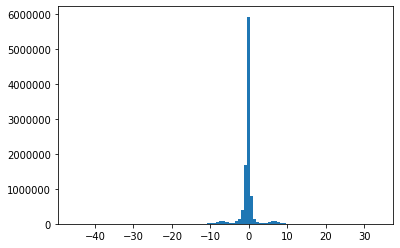

In [7]:
# Please use the sklearn.preprocessing.QuantileTransformer to transform each feature
# into a Gaussian
plt.hist(data.values[:, 0], bins=100);


In [9]:
data_transformed = # YOUR CODE

Результат должен выглядеть как-то так:
![image.png](https://github.com/yandexdataschool/mlhep2019/raw/master/notebooks/day-6/gauss.png)

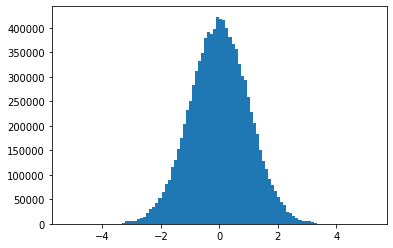

In [10]:
plt.hist(data_transformed[:, 0], bins=100);


In [11]:
train, test = train_test_split(data_transformed, test_size=0.1)
LATENT_DIM = 64 # Размерность "шума"


Здесь нашим генератором и дискриминатором может быть любая полносвязная сеть.

По желанию можно использовать шедулер :)

In [12]:
gen = # YOUR CODE
gen_opt = torch.optim.RMSprop(gen.parameters(), lr=1e-2)
gen_scheduler = # YOUR CODE

assert gen[0].in_features == LATENT_DIM + len(X_COLUMNS)
assert gen[-1].out_features == len(Y_COLUMNS)

In [13]:
disc = # YOUR CODE
disc_opt = torch.optim.RMSprop(disc.parameters(), lr=1e-2)
disc_scheduler = # YOUR CODE


assert disc[0].in_features == data.shape[1]
assert disc[-1].out_features == 1

In [14]:
TRAIN_BATCH_SIZE = 1024

def sample_real_data(batch_size):
    """
    Inifintly repeats and shuffles the train dataset, outputs the
    result in delicious batches.
    """
    while True:
        dataloader = torch.utils.data.DataLoader(train,
                                                 batch_size=batch_size,
                                                 shuffle=True, drop_last=True)
        for batch in dataloader:
            yield batch
            
infinite_data = sample_real_data(TRAIN_BATCH_SIZE)


In [15]:
# Эта функция семплит данные из вашего генератора
# Принимает на вход x (condition) 
# Возвращает concat(gen_y, x)

def sample_gen_data(x):
    noise = # YOUR CODE
    gen_input = torch.cat # YOUR CODE
    return torch.cat # YOUR CODE


In [16]:
test_sample = sample_gen_data(torch.from_numpy(train[:3, len(Y_COLUMNS):]).cuda())
assert test_sample.shape == (3, data.shape[1])


In [17]:
# https://github.com/caogang/wgan-gp/blob/master/gan_mnist.py

def calc_gradient_penalty_classic(critic:torch.nn.Module,
                                  real_data:torch.Tensor,
                                  fake_data:torch.Tensor):
    """
    Computes Gradient Penalty in random interpolates, in its classic form:
    (|∇(D(x)|^2 - 1)^2, x is interpolated between a real and a generated sample
    Args:
      critic: a torch model which gradient needs to be penalised
      real_data[batch_size, n_features]: a sample of real data
      fake_data[batch_size, n_features]: a sample of fake data
    Returns:
      torch.Tensor, scalar, gradient penalty evalute
    """
    assert real_data.shape == fake_data.shape
    alpha = torch.rand(real_data.shape[0], 1)
    alpha = alpha.expand(real_data.size()).cuda()

    interpolates = (alpha * real_data + ((1 - alpha) * fake_data)).cuda()
    interpolates = torch.autograd.Variable(interpolates, requires_grad=True)

    disc_interpolates = critic(interpolates)

    gradients = torch.autograd.grad(
        outputs=disc_interpolates, inputs=interpolates,
        grad_outputs=torch.ones(disc_interpolates.size(), device="cuda"),
        create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


In [18]:
LAMBDA = 1. # for gradient-penalty
def train_disc(gan_type):
    """
    Trains the discriminator for one step. Please note
    this is not a pure function, it captutes the majority of variables
    from the context.
    """
    real_data = next(infinite_data).to("cuda")
    x_gen = next(infinite_data)[:, len(Y_COLUMNS):].to("cuda")
    gen_data = sample_gen_data(x_gen)
    
    if gan_type == "JS":
        disc_loss = # YOUR CODE
    elif gan_type == "WGAN":
        disc_loss = # YOUR CODE
    elif gan_type == "LSGAN":
        disc_loss = # YOUR CODE
    elif gan_type == "WGAN-GP":
        disc_loss = # YOUR CODE
    else:
        raise ValueError("Unknown GAN type. Valid ones are: JS, WGAN-GP, WGAN, LSGAN")
    
    disc_opt.zero_grad()
    disc_loss.backward()
    disc_opt.step()
    return disc_loss


In [19]:
def train_gen(gan_type):
    """Trains generator for one step"""
    real_data_x = next(infinite_data)[:, len(Y_COLUMNS):].to("cuda")
    
    gen_data = sample_gen_data(real_data_x)
    
    if gan_type == "JS":
        gen_loss = # YOUR CODE
    elif gan_type == "WGAN":
        gen_loss = # YOUR CODE
    elif gan_type == "LSGAN":
        gen_loss = # YOUR CODE
    elif gan_type == "WGAN-GP":
        gen_loss = # YOUR CODE
    else:
        raise ValueError("Unknown GAN type. Valid ones are: JS, WGAN-GP, WGAN, LSGAN")
        
    gen_opt.zero_grad()
    gen_loss.backward()
    gen_opt.step()
    return gen_loss

In [24]:
experiment = Experiment()# YOUR INFO

ValueError: Comet.ml requires an API key. Please provide as the first argument to Experiment(api_key) or as an environment variable named COMET_API_KEY 

In [21]:
DISCRIMINATOR_ITERATIONS_PER_GENEREATOR = 5
VALIDATION_INTERVAL = 256
HIST_BINS=100
DATA_HIST_RANGE=[-5, 5]


In [22]:
data_linspace_np = np.linspace(0, 10, num=256, dtype=np.float32)
data_linspace_torch = torch.from_numpy(data_linspace_np)[:, None].cuda()
validation_data = torch.from_numpy(test).cuda()
validation_data_np = test
validation_x = validation_data[:, len(Y_COLUMNS):]

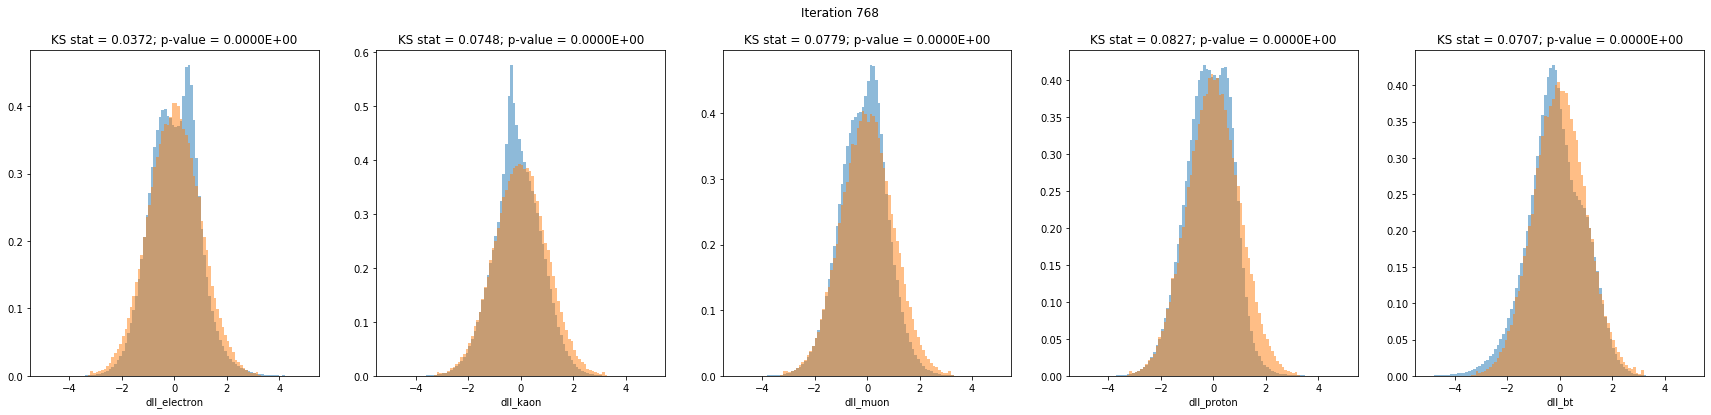

KeyboardInterrupt: 

In [23]:
for i in range(100000):
    gen_scheduler.step()
    disc_scheduler.step()
    for _ in range(DISCRIMINATOR_ITERATIONS_PER_GENEREATOR):
        disc_loss_this_iter = train_disc()
    
    gen_loss_this_iter = train_gen()
    experiment.log_metric('loss/discriminator', disc_loss_this_iter.item(), step=i)
    experiment.log_metric('loss/generator', gen_loss_this_iter.item(), step=i)

    if i % VALIDATION_INTERVAL == 0:
        clear_output(True)        
        validation_generated = sample_gen_data(validation_x)
        validation_generated_np = validation_generated.data.cpu().numpy()
        
        fig, axes_list = plt.subplots(ncols=5, figsize=[6*len(Y_COLUMNS), 6])
        for index, ax in enumerate(axes_list):
            ax.hist(validation_generated_np[:, index], range=DATA_HIST_RANGE,
                  alpha=0.5, density=True, label='Generated', bins=HIST_BINS)
            ax.hist(validation_data_np[:, index], range=DATA_HIST_RANGE,
                  alpha=0.5, density=True, label='Real', bins=HIST_BINS)
            ax.set_xlabel(data.columns[index])
            ks_result = ks_2samp(validation_generated_np[:, index],
                                    validation_data_np[:, index])
            ax.set_title("KS stat = {:.4f}; p-value = {:.4E}".format(*tuple(ks_result)))
        fig.suptitle("Iteration {}".format(i))
        plt.show()


### Метрика с классификатором, 2 балла

Одним из возможных способов подсчета качества вашего гана является качество классификатора обученного на разделение реальных и сгенерированных данных.

1. Возьмите модель, например catboost, xgboost или lightgbm
2. Сгененируйте достаточно большие выборки из реальных и сгенерированных данных (для каждой построенной вами модели)
3. Обучите модель на бинарную классификацию
4. Посчитайте ROC AUC модели, чем ближе к 0.5, тем лучше

### Обьяснения, 0.5 балла

1. Напишите, почему для одних ганов метрика выше чем для других.
2. Напишите как можно было бы улучшить те ганы которые у вас есть. 
3. Напишите, какие бы еще модели тут можно было бы попробовать